In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [5]:
df = pd.read_csv(r'datasets\NSE-Tata.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [6]:
df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")

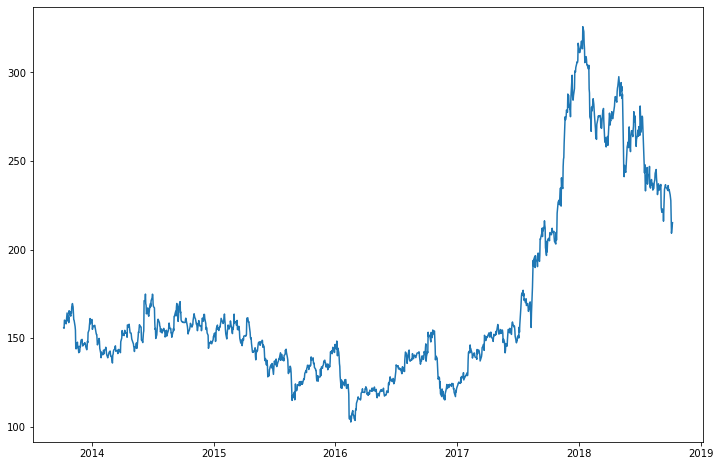

In [11]:
plt.figure(figsize=(12, 8))
df.index = df['Date']
plt.plot(df.Close, label='Close Price History')

In [12]:
data = df.sort_index(ascending=True, axis=0)
new_dataset=pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

for i in range(0, len(data)):
    new_dataset['Date'][i] = data['Date'][i]
    new_dataset['Close'][i] = data['Close'][i]

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis=1, inplace=True)

In [18]:
final_dataset = new_dataset.values


In [46]:
split = int(0.8 * final_dataset.shape[0])

train_data, val_data = final_dataset[:split], final_dataset[split:]


In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [48]:
scaled_data = scaler.fit_transform(final_dataset)

In [49]:
x_train, y_train = [], []

In [50]:
for i in range(60, len(train_data)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

In [51]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [52]:
x_train = np.reshape(x_train, (*x_train.shape, 1))

In [53]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

model.add(LSTM(units=50))
model.add(Dense(1))

In [54]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

928/928 - 4s - loss: 0.0011


In [56]:
inputs_data=new_dataset[len(new_dataset)-len(val_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [57]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

In [65]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [67]:
model.save("saved_lstm_model.h5")

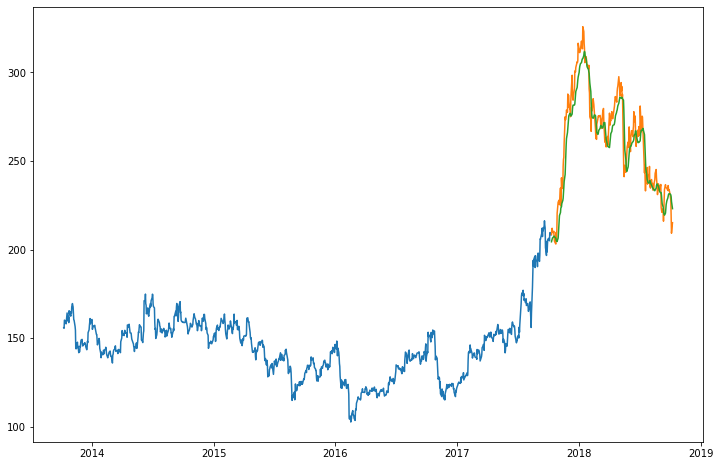

In [66]:
train_data=new_dataset[:split]
valid_data=new_dataset[split:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])